# 1. Pre-process data

In [ ]:
# construct training data for the model
import json

# Function to read a .jsonl file
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Parse each line as JSON and append to the data list
            data.append(json.loads(line))
            # break
    return data

movies_meta_data = read_jsonl('./data/meta_Movies_and_TV.jsonl')

In [ ]:
for movie in movies_meta_data:
    for key in movie.keys():
        print("{0}: {1}".format(key, movie[key]))
    print("*************************************************")
    print("title: {0}".format(movie['title']))
    print("description: {0}".format("".join(movie['description'])))
    break

main_category: Prime Video
title: Glee
subtitle: UnentitledUnentitled
average_rating: 4.7
rating_number: 2004
features: ['IMDb 6.8', '2013', '22 episodes', 'X-Ray', 'TV-14']
description: ['Entering its fourth season, this year the members of New Directions compete amongst themselves to be the "new Rachel" and hold auditions to find new students. Meanwhile, the graduating class leaves the comforts of McKinley where Rachel struggles to please her demanding NYADA teacher (Kate Hudson) and Kurt second-guesses his decision to stay in Lima. Four newcomers also join the musical comedy.']
price: 22.39
images: [{'360w': 'https://images-na.ssl-images-amazon.com/images/S/pv-target-images/8251ee0b9f888d262cd817a5f1aee0b29ffed56a4535af898b827292f881e169._RI_SX360_FMwebp_.jpg', '480w': 'https://images-na.ssl-images-amazon.com/images/S/pv-target-images/8251ee0b9f888d262cd817a5f1aee0b29ffed56a4535af898b827292f881e169._RI_SX480_FMwebp_.jpg', '720w': 'https://images-na.ssl-images-amazon.com/images/S/pv-

In [16]:
import json
# asins_small.json to be used for meta data matching
json_file_asins = './data/asins_small.json'
# json_file_asins = './data/meta_asins.json'
with open(json_file_asins, "r") as file:
    asin_dict = json.load(file)
    
asin_list = []
for asin in asin_dict:
    asin_list.append(asin)

In [ ]:
movies_meta_data = []
for asin in asin_list:
    title = asin_dict[asin][0]
    description = "".join(asin_dict[asin][1])
    if title is None or title.strip() == "" or description is None or description.strip() == "":
        continue
    movies_meta_data.append({"title": title, "description": description})

In [ ]:
movies_meta_data[0], len(movies_meta_data)

({'title': 'The Spitfire Grill',
  'description': 'Oscar-winner Ellen Burstyn (The Exorcist) headlines this critically praised drama about a young woman, just out of prison, who finds spiritual redemption working at a cafe in Maine.'},
 26846)

In [ ]:
# load and setup the model and tokenizer
from unsloth import FastLanguageModel

max_seq_length = 4096
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2b-it-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

def token_length(text):
    input_ids = tokenizer(text, return_tensors="pt").to("cuda")
    return len(input_ids[0])

prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"
prompt_template_token_length = token_length(prompt_template)
print("prompt_template_token_length: ", prompt_template_token_length)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
prompt_template_token_length:  11


In [ ]:
# construct dataset
from datasets import Dataset
from tqdm import tqdm

prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"

encoding_title_to_desc_task = {"input": [], "output": []}
encoding_desc_to_title_task = {"input": [], "output": []}
for movie in tqdm(movies_meta_data):
    title_to_desc_task_prompt_template = "Here is the title of a movie: ```{0}```\n Please write a description of the movie."
    desc_to_title_task_prompt_template = "Here is a description of a movie: ```{0}```\n Please write the title of the movie."
    if token_length(title_to_desc_task_prompt_template.format(movie['title']) + "".join(movie['description'])) <= max_seq_length - prompt_template_token_length:
        encoding_title_to_desc_task["input"].append(title_to_desc_task_prompt_template.format(movie['title']))
        encoding_title_to_desc_task["output"].append("".join(movie['description']))
        encoding_desc_to_title_task["input"].append(desc_to_title_task_prompt_template.format("".join(movie['description'])))
        encoding_desc_to_title_task["output"].append(movie['title'])

encoding_title_to_desc_task = Dataset.from_dict(encoding_title_to_desc_task)
encoding_desc_to_title_task = Dataset.from_dict(encoding_desc_to_title_task)

# encoding_title_to_desc_task = encoding_title_to_desc_task.train_test_split(test_size=0.007)
# encoding_title_to_desc_task_dataset_train, encoding_title_to_desc_task_dataset_eval = encoding_title_to_desc_task["train"], encoding_title_to_desc_task["test"]
# encoding_desc_to_title_task = encoding_desc_to_title_task.train_test_split(test_size=0.007)
# encoding_desc_to_title_task_dataset_train, encoding_desc_to_title_task_dataset_eval = encoding_desc_to_title_task["train"], encoding_desc_to_title_task["test"]

100%|██████████| 26846/26846 [00:44<00:00, 603.85it/s]


In [ ]:
encoding_title_to_desc_task, encoding_desc_to_title_task, # before length filtering, num_rows = 434236
# encoding_title_to_desc_task_dataset_train, encoding_title_to_desc_task_dataset_eval, encoding_desc_to_title_task_dataset_train, encoding_desc_to_title_task_dataset_eval

(Dataset({
     features: ['input', 'output'],
     num_rows: 26837
 }),
 Dataset({
     features: ['input', 'output'],
     num_rows: 26837
 }))

In [ ]:
# save huggingface dataset to local
encoding_title_to_desc_task.save_to_disk('./data/encoding_title_to_desc_task_fixed_empty_string_filter')
encoding_desc_to_title_task.save_to_disk('./data/encoding_desc_to_title_task_fixed_empty_string_filter')

Saving the dataset (0/1 shards):   0%|          | 0/26837 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/26837 [00:00<?, ? examples/s]

Map:   0%|          | 0/434213 [00:00<?, ? examples/s]

100%|██████████| 434213/434213 [05:26<00:00, 1328.77it/s]


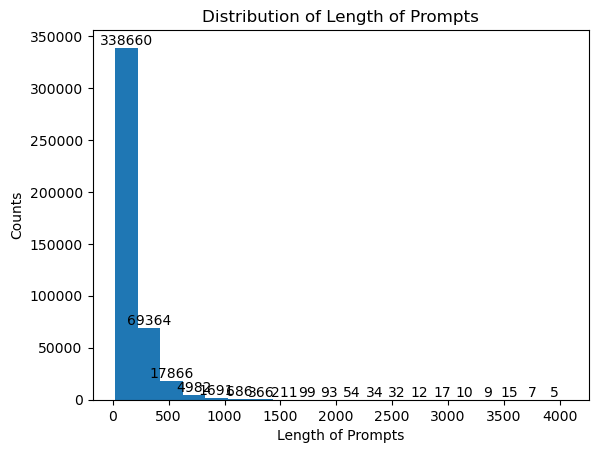

In [ ]:
# Get the distribution of length of (input + output) text in training dict
import matplotlib.pyplot as plt
from tqdm import tqdm

encoding_title_to_desc_task_combined = encoding_title_to_desc_task.map(lambda x: {"combined_text": x["input"] + x["output"]})

length_of_input_plus_output = []
for text in tqdm(encoding_title_to_desc_task_combined['combined_text']):
    length_of_input_plus_output.append(token_length(text))

# Create the histogram and get the number of occurrences and the bin edges
counts, bins, patches = plt.hist(length_of_input_plus_output, bins=20)

# Loop over the patches (bars) and add a text label above each bar
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 5, str(int(count)),
             ha='center', va='bottom')

plt.xlabel('Length of Prompts')
plt.ylabel('Counts')
plt.title('Distribution of Length of Prompts')
plt.show()

# 2. Training Encoding model

In [ ]:
import json
from datetime import datetime

import torch
from datasets import load_from_disk
from unsloth import FastLanguageModel

hyper_params = {
    # Model hyperparameters
    "max_seq_length": 4096, # 8192 | Choose any! We auto support RoPE Scaling internally!
    "dtype": None, # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    "load_in_4bit": True, # Use 4bit quantization to reduce memory usage. Can be False.,
    "model_name": "unsloth/gemma-2b-it-bnb-4bit",
    "r": 8, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128,
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Add more to target more modules
    "lora_alpha": 16,
    "lora_dropout": 0, # Supports any, but = 0 is optimized
    "lora_bias": "none", # Supports any, but = "none" is optimized
    "lora_use_gradient_checkpointing": "unsloth", # True or "unsloth" for very long context
    "lora_random_state": 3407,
    "lora_use_rslora": False, # We support rank stabilized LoRA
    "lora_loftq_config": None, # And LoftQ
    # Training hyperparameters
    "encoding_title_to_desc_task_path": "./data/encoding_title_to_desc_task",
    "encoding_desc_to_title_task_path": "./data/encoding_desc_to_title_task",
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 1,
    "warmup_steps": 25, # will replace num_warmup_steps in lr_scheduler_kwargs
    "num_train_epochs": 2,
    "learning_rate": 2e-4,
    "fp16": not torch.cuda.is_bf16_supported(),
    "bf16": torch.cuda.is_bf16_supported(),
    "logging_steps": 1,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "cosine_with_restarts",
    "lr_scheduler_kwargs": {"num_cycles": 3}, # "num_warmup_steps" and "num_training_steps" will be added automatically
    "seed": 3407,
}

In [ ]:
# load model and tokenizer
model, tokenizer= FastLanguageModel.from_pretrained(
    model_name = hyper_params["model_name"], # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = hyper_params["max_seq_length"],
    dtype = hyper_params["dtype"],
    load_in_4bit = hyper_params["load_in_4bit"],
)

==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


In [ ]:
# add lora to model
model = FastLanguageModel.get_peft_model(
    model,
    r = hyper_params['r'],
    target_modules = hyper_params['target_modules'],
    lora_alpha = hyper_params['lora_alpha'],
    lora_dropout = hyper_params['lora_dropout'],
    bias = hyper_params['lora_bias'],
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = hyper_params['lora_use_gradient_checkpointing'],
    random_state = hyper_params['lora_random_state'],
    use_rslora = hyper_params['lora_use_rslora'], # We support rank stabilized LoRA
    loftq_config = hyper_params['lora_loftq_config'], # And LoftQ
)

Unsloth 2024.4 patched 18 layers with 18 QKV layers, 18 O layers and 18 MLP layers.


## 2.1 Train encoding_title_to_desc_task

In [ ]:
# read huggingface dataset from local
encoding_title_to_desc_task = load_from_disk(hyper_params["encoding_title_to_desc_task_path"])

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

prompt_template = prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"

def formatting_prompts_func(examples):
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []

    for input, output in zip(inputs, outputs):
        # text = "### Input:\n{inputs_holder}\n\n### Response:{outputs_holder}".format(inputs_holder= input, outputs_holder= output) + EOS_TOKEN
        # gemma chat template:
        text = prompt_template.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

train_dataset = encoding_title_to_desc_task.map(formatting_prompts_func, batched = True,)
# train_dataset = encoding_desc_to_title_task.map(formatting_prompts_func, batched = True,)

# take samples from the dataset
train_dataset = train_dataset.shuffle(seed=hyper_params["seed"])
train_dataset = train_dataset.select(range(100))

In [ ]:
# training
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    # eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = hyper_params['max_seq_length'],
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = hyper_params['per_device_train_batch_size'],
        gradient_accumulation_steps = hyper_params['gradient_accumulation_steps'],
        warmup_steps = hyper_params['warmup_steps'],
        num_train_epochs = hyper_params['num_train_epochs'],
        # max_steps = 100,
        learning_rate = hyper_params['learning_rate'],
        fp16 = hyper_params['fp16'],
        bf16 = hyper_params['bf16'],
        logging_steps = hyper_params['logging_steps'],
        optim = hyper_params['optim'],
        weight_decay = hyper_params['weight_decay'],
        lr_scheduler_type = hyper_params['lr_scheduler_type'],
        lr_scheduler_kwargs = hyper_params['lr_scheduler_kwargs'],
        seed = hyper_params['seed'],
        output_dir = "outputs",
        # fp16_full_eval = True,
        # per_device_eval_batch_size = 1,
        # eval_accumulation_steps = 1,
        # evaluation_strategy = "steps", # epoch
        # eval_steps = 100,
    ),
)

Map (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 100 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 1
\        /    Total batch size = 2 | Total steps = 100
 "-____-"     Number of trainable parameters = 9,805,824


Step,Training Loss
1,6.863800
2,6.494600
3,6.115700
4,5.545300
5,5.275700
6,5.773700
7,4.764100
8,4.283300
9,3.856800
10,5.017600


In [ ]:
# saving model and loss history
# get current datetime
now = datetime.now()

# name the model
model_name = "e_t2d_model_" + now.strftime("%m%d%Y_%H%M%S")
model_path = "outputs/" + model_name
model.save_pretrained(model_path) # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

# save hyperparameters as a json dict to model_path
with open(model_path + "/hyperparameters.json", "w") as file:
    json.dump(hyper_params, file, indent=4)
        
# save trainer.state.log_history to model_path
with open(model_path + "/trainer_state_log_history.json", "w") as file:
    json.dump(trainer.state.log_history, file, indent=4)

## 2.2 Train encoding_desc_to_title_task

In [ ]:
# clear the cache
import torch

torch.cuda.empty_cache()

In [ ]:
# similarly, we can train the model for encoding_desc_to_title_task......
# read huggingface dataset from local
encoding_desc_to_title_task = load_from_disk(hyper_params["encoding_desc_to_title_task_path"])

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

prompt_template = prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"

def formatting_prompts_func(examples):
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []

    for input, output in zip(inputs, outputs):
        # text = "### Input:\n{inputs_holder}\n\n### Response:{outputs_holder}".format(inputs_holder= input, outputs_holder= output) + EOS_TOKEN
        # gemma chat template:
        text = prompt_template.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

train_dataset = encoding_desc_to_title_task.map(formatting_prompts_func, batched = True,)

# take samples from the dataset
train_dataset = train_dataset.shuffle(seed=hyper_params["seed"])
train_dataset = train_dataset.select(range(100))

Map:   0%|          | 0/434213 [00:00<?, ? examples/s]

In [ ]:
# training
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    # eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = hyper_params['max_seq_length'],
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = hyper_params['per_device_train_batch_size'],
        gradient_accumulation_steps = hyper_params['gradient_accumulation_steps'],
        warmup_steps = hyper_params['warmup_steps'],
        num_train_epochs = hyper_params['num_train_epochs'],
        # max_steps = 100,
        learning_rate = hyper_params['learning_rate'],
        fp16 = hyper_params['fp16'],
        bf16 = hyper_params['bf16'],
        logging_steps = hyper_params['logging_steps'],
        optim = hyper_params['optim'],
        weight_decay = hyper_params['weight_decay'],
        lr_scheduler_type = hyper_params['lr_scheduler_type'],
        lr_scheduler_kwargs = hyper_params['lr_scheduler_kwargs'],
        seed = hyper_params['seed'],
        output_dir = "outputs",
        # fp16_full_eval = True,
        # per_device_eval_batch_size = 1,
        # eval_accumulation_steps = 1,
        # evaluation_strategy = "steps", # epoch
        # eval_steps = 100,
    ),
)

Map (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

Step,Training Loss
1,3.218400
2,3.286000
3,3.059500
4,3.000300
5,2.343000
6,2.728500
7,2.932600
8,3.518000
9,2.929600
10,2.752800


In [ ]:
# saving model and loss history
# get current datetime
now = datetime.now()

# name the model
model_name = "e_d2t_model_" + now.strftime("%m%d%Y_%H%M%S")
model_path = "outputs/" + model_name
model.save_pretrained(model_path) # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

# save hyperparameters as a json dict to model_path
with open(model_path + "/hyperparameters.json", "w") as file:
    json.dump(hyper_params, file, indent=4)
        
# save trainer.state.log_history to model_path
with open(model_path + "/trainer_state_log_history.json", "w") as file:
    json.dump(trainer.state.log_history, file, indent=4)

# 3. Inference

In [40]:
# check the training results
title_to_desc_task_prompt_template = "Here is the title of a movie: ```{0}```\n Please write a description of the movie."
desc_to_title_task_prompt_template = "Here is a description of a movie: ```{0}```\n Please write the title of the movie."
    
test_input = title_to_desc_task_prompt_template.format("Seven Samurai")
# test_input = desc_to_title_task_prompt_template.format("Neo is a engineer, but he is also a hacker. One day, he meets Trinity, a beautiful stranger who leads him into the real world.")
# test_input = desc_to_title_task_prompt_template.format("A samurai answers a village's request for protection after he falls on hard times. The town needs protection from bandits, so the samurai gathers six others to help him teach the people how to defend themselves, and the villagers provide the soldiers with food. A giant battle occurs when 40 bandits attack the village.")

In [41]:
from transformers import TextStreamer, GenerationConfig
from unsloth import FastLanguageModel
import torch

max_seq_length = 4096 # 8192 | Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
    
model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "outputs/model_04242024_090830/", # YOUR MODEL YOU USED FOR TRAINING
    # model_name = "unsloth/gemma-2b-it-bnb-4bit",
    # model_name = "outputs/checkpoint-1000",
    model_name = "outputs/e_t2d_model_05152024_002328",
    # model_name = "outputs/e_d2t_model_05152024_032245",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
        
prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"
inputs = tokenizer(
[
    prompt_template.format(test_input, ""),    
], return_tensors = "pt").to("cuda")

# num_beams_parameter = 5
# custom_generation_config = GenerationConfig(
#     bos_token_id=tokenizer.bos_token_id,
#     eos_token_id=tokenizer.eos_token_id,
#     pad_token_id=tokenizer.pad_token_id,
#     asin_dict=None,
#     tokenizer=tokenizer,
#     return_dict_in_generate=True,
#     output_scores=True,
#     # output_logits=True,
#     do_sample=True,
#     early_stopping=True,
#     num_beams=num_beams_parameter, 
#     num_return_sequences=num_beams_parameter,
#     max_new_tokens=1024,
#     use_cache=True,
#     temperature=1,
#     # num_beam_groups=5, # In this generation mode, `num_beams` should be divisible by `num_beam_groups`. `diversity_penalty` is not 0.0 or `num_beam_groups` is not 1, triggering group beam search. 
#     # diversity_penalty=0.9, # `diversity_penalty` should be greater than `0.0`, otherwise your groups will be identical.
#     output_hidden_states=True,
# )

# outputs = model.generate(**inputs, generation_config=custom_generation_config)
outputs = model.generate(**inputs, max_new_tokens=1, use_cache=True, return_dict_in_generate=True, output_hidden_states=True,)
# check CUDA memory usage
used_memory = round(torch.cuda.max_memory_allocated() / 1024 / 1024 / 1024, 3)
# if used_memory close to 14GB, empty the cache
if used_memory > 14.3:
    torch.cuda.empty_cache()
    print("CUDA memory usage is high. Cleared the cache.")

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [3]:
# for i in range(num_beams_parameter):
#     # print(outputs['sequences'][i])
#     print("Generated text: ", "".join(tokenizer.decode(outputs['sequences'][i], skip_special_tokens=True)))
#     print("*************************************************")

print("Generated text: ", "".join(tokenizer.decode(outputs['sequences'][0], skip_special_tokens=True)))
print("*************************************************")

Generated text:  user
Here is the title of a movie: ```Seven Samurai```
 Please write a description of the movie.
model
Product DescriptionSeven Samurai (DVD) (WS)Academy Award-winning director Akira Kurosawa (Rashomon, The Hidden Fortress) brings to life the epic tale of a band of 100 samurai who, in the wake of the Civil War, are hired by a wealthy landowner to defend his land and his people. The film is a sweeping epic of honor, loyalty and love, and a powerful story of the human spirit in the face of great adversity. The film stars Toshiro Mifune as the samurai leader, and is a masterpiece of samurai cinema.]]>Amazon.comSeven Samuraiis a classic samurai epic, a sweeping, epic tale of honor, loyalty, and love, and a powerful story of the human spirit in the face of great adversity. The film stars Toshiro Mifune as the samurai leader, and is a masterpiece of samurai cinema. The film is set in the aftermath of the Civil War, and the samurai are hired by a wealthy landowner to defend h

In [9]:
print("input length: ", len(inputs[0]))
print("full length: ", len(outputs['sequences'][0]))
print("newly generated token sequence length: ", len(outputs['sequences'][0]) - len(inputs[0]))

input length:  30
full length:  542
newly generated token sequence length:  512


In [18]:
# hidden states
# first [0] means the prefix embeddings.
# second [-1] means take the last layer embeddings.
print("last layer embeddings' shape: ", outputs.hidden_states[0][-1].shape) # embeddings, with the length of prefix
# take average of the embeddings
averaged_emb = outputs.hidden_states[0][-1].mean(dim=1)
averaged_emb, averaged_emb.shape

last layer embeddings' shape:  torch.Size([1, 30, 2048])


(tensor([[-0.0771, -0.1932, -0.1176,  ..., -0.8994, -0.8442, -0.6426]],
        device='cuda:0', dtype=torch.float16),
 torch.Size([1, 2048]))

### 3.1 Generating ground-truth embeddings

In [2]:
# get the groud-truth movies
import json

with open('./data/gemma_chat_training_wo_description_fixed_empty_string_filter.json', 'r') as file:
    gemma_train_wo_description = json.load(file)
len(gemma_train_wo_description)

2

# 4. Predicting model

## 4.1 construct training dataset

In [35]:
# def asin_dict_to_t2d_dict(original_dictionary):
#     new_dictionary = {}
#     for key, movie in asin_dict.items():
#         new_dictionary[movie[0]] = ' '.join(movie[1])
#     return new_dictionary

# title_to_description_dict = asin_dict_to_t2d_dict(asin_dict)

In [43]:
# # generate the embeddings of movies using the t2d model
# def get_embedding_from_t2d_by_title(title):
    
#     title_to_desc_task_prompt_template = "Here is the title of a movie: ```{0}```\n Please write a description of the movie."
#     # generate input
#     inputs = tokenizer(
#     [
#         prompt_template.format(title_to_desc_task_prompt_template, title),    
#     ], return_tensors = "pt").to("cuda")
#     outputs = model.generate(**inputs, max_new_tokens=512, use_cache=True, return_dict_in_generate=True, output_hidden_states=True,)
    
#     # get the averaged output vector of the prefix(prompt)
#     embedding = outputs.hidden_states[0][-1].mean(dim=1)
#     return embedding


# def get_embedding_from_d2t_by_title(title):
#     description = title_to_description_dict[title]
#     desc_to_title_task_prompt_template = "Here is a description of a movie: ```{0}```\n Please write the title of the movie."
#     # generate input
#     inputs = tokenizer(
#     [
#         desc_to_title_task_prompt_template.format(title_to_desc_task_prompt_template, description),    
#     ], return_tensors = "pt").to("cuda")
#     outputs = model.generate(**inputs, max_new_tokens=512, use_cache=True, return_dict_in_generate=True, output_hidden_states=True,)
    
#     # get the averaged output vector of the prefix(prompt)
#     embedding = outputs.hidden_states[0][-1].mean(dim=1)
#     return embedding

In [37]:
# # get a list of five titles to test
# test_title_list = gemma_train_wo_description['output'][:5]

In [ ]:
# # test
# for title in test_title_list:
#     embedding_from_t2d = get_embedding_from_t2d_by_title(title)
#     embedding_from_d2t = get_embedding_from_d2t_by_title(title)
#     print("t2d embedding shape:", embedding_from_t2d.shape)
#     print("d2t embedding shape:", embedding_from_d2t.shape)
#     print(embedding_from_t2d)
#     print(embedding_from_d2t)

In [47]:
# # store the movie titles and tensors as key-value pairs
# import h5py

# def save_tensors(tensors, file_name):
#     with h5py.File(file_name, 'w') as h5f:
#         for key, tensor in tensors.items():
#             h5f.create_dataset(key, data=tensor.numpy())  # Convert to numpy before saving

In [ ]:
# from tqdm import tqdm
# title_t2d_embedding_dict = {}
# title_d2t_embedding_dict = {}
# for title in tqdm(gemma_train_wo_description['output']):
#     embedding_from_t2d = get_embedding_from_t2d_by_title(title)
#     embedding_from_d2t = get_embedding_from_d2t_by_title(title)
#     title_t2d_embedding_dict[title] = embedding_from_t2d
#     title_d2t_embedding_dict[title] = embedding_from_d2t

# title_t2d_embedding_file = "data/title_t2d_hidden_state_output.hdf5"
# title_d2t_embedding_file = "data/title_d2t_hidden_state_output.hdf5"


# save_tensors(title_t2d_embedding_dict, title_t2d_embedding_file)
# save_tensors(title_d2t_embedding_dict, title_d2t_embedding_file)

In [21]:
# load the embeddings from title_sbert_encoding.json
import json
import torch

# Load from JSON file
with open('data/title_sbert_encoding_wo_category.json', 'r') as file:
    loaded_data = json.load(file)
# Convert lists back to tensors
data = {key: torch.tensor(value) for key, value in loaded_data.items()}
print(len(data))

6046


In [18]:
# with open('data/gemma_chat_training_wo_description_fixed_empty_string_filter.json', 'r') as file:
#     training_data = json.load(file)
# with open('data/gemma_chat_training_w_description_fixed_empty_string_filter.json', 'r') as file:
#     training_data = json.load(file)
    
# read huggingface dataset from local
from datasets import load_from_disk

training_data = load_from_disk("./data/gemma_chat_train_fixed_empty_string_filter")
eval_data = load_from_disk('./data/gemma_chat_eval_fixed_empty_string_filter')

In [22]:
test_index = 0
training_data['input'][test_index], training_data['output'][test_index]

("Below is the previous historical purchases and reviews of the user:\n```\nItem title: Hotel Transylvania: 3-Movie DVD Collection \n Item description: Disc 1 - Hotel Transylvania & Hotel Transylvania 2 Disc 2 - Hotel Transylvania 3 Hotel Transylvania Welcome to Hotel Transylvania, Dracula’s lavish five-stake resort, where monsters and their families can live it up and no humans are allowed. Hotel Transylvania 2 The Drac-Pack is back in this hilarious comedy starring Drac, Mavis, Johnny and your favourite monsters in an all-new adventure! Hotel Transylvania 3 Join Drac, Mavis and all of your favourite monsters for fun and adventure on the high seas as they embark on a monster cruise vacation! \n rating: 5.0 \n review: Movies 1 & 2 are on the same disc. You’ll get 2 disks for the 3 movies. Our digital code worked for movie 3. Bummed it wasn’t included for all 3, but I wasn’t expecting one for the 3rd movie anyway. So that was kind of a bonus.-------\n```\nAnd here is the user's intentio

In [24]:
from tqdm import tqdm
# ABORT: not including categories in the training data
# new_training_data = {"input": [], "output": []}
# for i in range(len(training_data['input'])):
#     new_input = training_data['input'][i] 
#     new_output = training_data['output'][i]
    
#     new_input = ".".join(new_input.split(".")[:-2]) + ". Please give the title, description and categories of the recommended item."
#     new_output = data[new_output]
    
#     new_training_data['input'].append(new_input)
#     new_training_data['output'].append(new_output)

new_training_data = {"input": [], "output": []}
for i in tqdm(range(len(training_data['input']))):
    new_input = training_data['input'][i] 
    if training_data['output'][i].startswith("Title: "):
        new_output = training_data['output'][i].split("\n")[0].split("Title: ")[1].strip()
    else:
        new_output = training_data['output'][i]
    
    new_output = data[new_output]
    
    new_training_data['input'].append(new_input)
    new_training_data['output'].append(new_output)

new_eval_data = {"input": [], "output": []}
for i in tqdm(range(len(eval_data['input']))):
    new_input = eval_data['input'][i] 
    if eval_data['output'][i].startswith("Title: "):
        new_output = eval_data['output'][i].split("\n")[0].split("Title: ")[1].strip()
    else:
        new_output = eval_data['output'][i]
    
    new_output = data[new_output]
    
    new_eval_data['input'].append(new_input)
    new_eval_data['output'].append(new_output)

  0%|          | 0/14507 [00:00<?, ?it/s]

100%|██████████| 103/103 [00:00<00:00, 1006.32it/s]


In [27]:
# new_training_data["input"][0], new_training_data["output"][0]
len(new_training_data["input"]), len(new_training_data["output"]), \
len(new_eval_data["input"]), len(new_eval_data["output"])

(14507, 14507, 103, 103)

In [30]:
from datasets import Dataset

dataset_predict_emb_task = Dataset.from_dict(new_training_data)
dataset_predict_emb_task_test = Dataset.from_dict(new_eval_data)

dataset_predict_emb_task = dataset_predict_emb_task.train_test_split(test_size=0.025)
dataset_predict_emb_task_train, dataset_predict_emb_task_eval = dataset_predict_emb_task["train"], dataset_predict_emb_task["test"]

In [31]:
dataset_predict_emb_task_train, dataset_predict_emb_task_eval, dataset_predict_emb_task_test

(Dataset({
     features: ['input', 'output'],
     num_rows: 14144
 }),
 Dataset({
     features: ['input', 'output'],
     num_rows: 363
 }),
 Dataset({
     features: ['input', 'output'],
     num_rows: 103
 }))

In [32]:
dataset_predict_emb_task_train.save_to_disk('./data/gemma_chat_train_predict_emb_task_fixed_empty_string_filter')
dataset_predict_emb_task_eval.save_to_disk('./data/gemma_chat_eval_predict_emb_task_fixed_empty_string_filter')
dataset_predict_emb_task_test.save_to_disk('./data/gemma_chat_test_predict_emb_task_fixed_empty_string_filter')

Saving the dataset (0/1 shards):   0%|          | 0/14144 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/363 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/103 [00:00<?, ? examples/s]

## 4.2 Distance based loss function - training

In [14]:
# read huggingface dataset from local
from datasets import load_from_disk

dataset_train = load_from_disk("./data/gemma_chat_train_predict_emb_task_fixed_empty_string_filter")
dataset_eval = load_from_disk("./data/gemma_chat_eval_predict_emb_task_fixed_empty_string_filter")
dataset_test = load_from_disk("./data/gemma_chat_test_predict_emb_task_fixed_empty_string_filter")

In [46]:
print(dataset_train.select(range(5)))

Dataset({
    features: ['input', 'output'],
    num_rows: 5
})


In [23]:
dataset_train[0]["input"]

'Below is the previous historical purchases and reviews of the user:\n```\nItem title: The Big Bang Theory: Season 6 \n Item description: Big Bang Theory, The: The Complete Sixth Season (DVD) The CalTech geniuses of The Big Bang Theory return for season six after being thrown for a bell curve in the phenomenally funny fifth season of the hit show. In “TV’s top-rated comedy” (New York Post), Leonard has to “debug” his relationship with Penny once more after accidentally proposing to her in the heat of the moment, while Sheldon, Howard, and Raj continue to discover the feminine mystique is something that cannot be easily graphed or calculated. With even greater personal contact with his not girlfriend but “friend-who-happens-to-be-a-girl” Amy Farrah Fowler, Sheldon might have to make even more begrudging amendments to his “Relationship Agreement” while Raj continues to look for a girl as nice as Siri, and Howard gets ready for splashdown in both his NASA space travels and wedding to the 

In [19]:
# tokenize the input from string to tensor
from unsloth import FastLanguageModel

_, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2b-it-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = 4096,
    dtype = None,
    load_in_4bit = True,
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [25]:
tokenizer("input", return_tensors="pt", padding="max_length")["input_ids"][:, :4096].shape

torch.Size([1, 4096])

In [26]:
# init tokenized dataset
tokenized_train_dataset = {"input": [], "output": []}
tokenized_eval_dataset = {"input": [], "output": []}
tokenized_test_dataset = {"input": [], "output": []}

# iterate through the dataset and tokenize the input
for i in range(len(dataset_train)):
    tokenized_train_dataset["input"].append(tokenizer(dataset_train[i]["input"], return_tensors="pt")['input_ids'][:, :4096])
    tokenized_train_dataset["output"].append(dataset_train[i]["output"])
    
for i in range(len(dataset_eval)):
    tokenized_eval_dataset["input"].append(tokenizer(dataset_eval[i]["input"], return_tensors="pt")['input_ids'][:, :4096])
    tokenized_eval_dataset["output"].append(dataset_eval[i]["output"])

for i in range(len(dataset_test)):
    tokenized_test_dataset["input"].append(tokenizer(dataset_test[i]["input"], return_tensors="pt")['input_ids'][:, :4096])
    tokenized_test_dataset["output"].append(dataset_test[i]["output"])

In [27]:
from datasets import Dataset

tokenized_train_dataset = Dataset.from_dict(tokenized_train_dataset)
tokenized_eval_dataset = Dataset.from_dict(tokenized_eval_dataset)
tokenized_test_dataset = Dataset.from_dict(tokenized_test_dataset)

In [28]:
# save the tokenized dataset
tokenized_train_dataset.save_to_disk('./data/gemma_chat_train_predict_emb_task_fixed_empty_string_filter_tokenized')
tokenized_eval_dataset.save_to_disk('./data/gemma_chat_eval_predict_emb_task_fixed_empty_string_filter_tokenized')
tokenized_test_dataset.save_to_disk('./data/gemma_chat_test_predict_emb_task_fixed_empty_string_filter_tokenized')

Saving the dataset (0/1 shards):   0%|          | 0/14144 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/363 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/103 [00:00<?, ? examples/s]

In [1]:
# read huggingface dataset from local
from datasets import load_from_disk

# read the tokenized data
tokenized_train_dataset = load_from_disk('./data/gemma_chat_train_predict_emb_task_fixed_empty_string_filter_tokenized')
tokenized_eval_dataset = load_from_disk('./data/gemma_chat_eval_predict_emb_task_fixed_empty_string_filter_tokenized')
tokenized_test_dataset = load_from_disk('./data/gemma_chat_test_predict_emb_task_fixed_empty_string_filter_tokenized')

In [2]:
type(tokenized_train_dataset[0]["input"]),\
type(tokenized_train_dataset[0]["output"])

(list, list)

In [7]:
len_to_be_padded = 4096 - len(tokenized_test_dataset[0]["input"][0])
# len_to_be_padded
# add len_to_be_padded 0 to the end of tokenized_test_dataset[0]["input"][0]
import torch
from torch import zeros

tensor = torch.tensor(tokenized_test_dataset[0]["input"])
# pad to the last dimension
padded_tensor = torch.nn.functional.pad(tensor, (0, len_to_be_padded), "constant", 0)
padded_tensor.shape, padded_tensor

(torch.Size([1, 4096]),
 tensor([[    2, 33501,   603,  ...,     0,     0,     0]]))

In [2]:
import json
from datetime import datetime

import torch
from datasets import load_from_disk
from unsloth import FastLanguageModel

hyper_params = {
    # Model hyperparameters
    "max_seq_length": 4096, # 8192 | Choose any! We auto support RoPE Scaling internally!
    "dtype": None, # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    "load_in_4bit": True, # Use 4bit quantization to reduce memory usage. Can be False.,
    # "model_name": "unsloth/gemma-2b-it-bnb-4bit",
    "model_name": "outputs/model_05152024_105402_merged_16bit",
    "r": 8, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128,
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Add more to target more modules
    "lora_alpha": 16,
    "lora_dropout": 0, # Supports any, but = 0 is optimized
    "lora_bias": "none", # Supports any, but = "none" is optimized
    "lora_use_gradient_checkpointing": "unsloth", # True or "unsloth" for very long context
    "lora_random_state": 3407,
    "lora_use_rslora": False, # We support rank stabilized LoRA
    "lora_loftq_config": None, # And LoftQ
    # Training hyperparameters
    "dataset_train_path": "./data/gemma_chat_train_no_user_intention_fixed_empty_string_filter",
    "dataset_eval_path": "./data/gemma_chat_eval_no_user_intention_fixed_empty_string_filter",
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 1,
    "warmup_steps": 25, # will replace num_warmup_steps in lr_scheduler_kwargs
    "num_train_epochs": 1,
    "learning_rate": 2e-4,
    "fp16": not torch.cuda.is_bf16_supported(),
    "bf16": torch.cuda.is_bf16_supported(),
    "logging_steps": 1,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "cosine_with_restarts",
    "lr_scheduler_kwargs": {"num_cycles": 3}, # "num_warmup_steps" and "num_training_steps" will be added automatically
    "seed": 3407,
}

# load model and tokenizer
model, tokenizer= FastLanguageModel.from_pretrained(
    model_name = hyper_params["model_name"], # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = hyper_params["max_seq_length"],
    dtype = hyper_params["dtype"],
    load_in_4bit = hyper_params["load_in_4bit"],
    )

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
# model.save_pretrained_merged(hyper_params["model_name"] + "_merged_16bit", tokenizer, save_method = "merged_16bit",)

Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.31 out of 12.68 RAM for saving.


100%|██████████| 18/18 [00:00<00:00, 22.44it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving outputs/model_05152024_105402_merged_16bit/pytorch_model-00001-of-00002.bin...
Unsloth: Saving outputs/model_05152024_105402_merged_16bit/pytorch_model-00002-of-00002.bin...
Done.


In [3]:
# # show the module architecture of the model
# for name, module in model.named_children():
#     print(f"\t{name}")
#     if isinstance(module, torch.nn.Module):
#         print(f"\t\t{module}")

print(model)

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaFixedRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )


In [6]:
model.lm_head, model.lm_head.weight.shape, model.lm_head.weight

(Linear(in_features=2048, out_features=256000, bias=False),
 torch.Size([256000, 2048]),
 Parameter containing:
 tensor([[ 5.2344e-01, -3.5889e-02,  5.9814e-02,  ...,  7.7637e-02,
           2.3535e-01,  3.8330e-02],
         [ 1.5137e-01, -1.4453e-01, -1.1719e-01,  ..., -1.9409e-02,
           4.9133e-03, -2.0508e-02],
         [ 1.0352e-01,  5.0354e-03, -3.2715e-02,  ..., -1.7334e-02,
          -8.9111e-03, -1.0254e-02],
         ...,
         [ 2.7344e-01,  1.2390e-02,  4.2236e-02,  ..., -4.8584e-02,
           1.9165e-02, -3.0151e-02],
         [ 2.9102e-01, -6.4453e-02,  6.2012e-02,  ..., -1.9653e-02,
           7.1289e-02, -1.6689e-04],
         [ 5.2344e-01, -3.5156e-02,  6.0791e-02,  ...,  7.6172e-02,
           2.3828e-01,  3.9795e-02]], device='cuda:0', dtype=torch.float16))

In [7]:
import torch.nn as nn

m = nn.GELU()
input = torch.tensor([-19.23, 30.112]) # torch.randn(2)
print(input)
output = m(input)
print(output)

tensor([-19.2300,  30.1120])
tensor([-0.0000, 30.1120])


In [4]:
import torch
import torch.nn as nn

# Assume `model` is your pre-trained model
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Define a custom module with multi-head attention
class MultiheadAttentionLayer(nn.Module):
    def __init__(self, embed_dim, internal_dim, output_dim, num_heads):
        super(MultiheadAttentionLayer, self).__init__()
        self.input_linear = nn.Linear(embed_dim, internal_dim)
        self.gelu_1 = nn.GELU()
        self.multihead_attn = nn.MultiheadAttention(internal_dim, num_heads)
        self.layer_norm = nn.LayerNorm(internal_dim)
        # self.dropout = nn.Dropout(0.1)
        self.output_linear = nn.Linear(internal_dim, output_dim)
        # self.gelu = nn.GELU()
        # self.out_proj = nn.Linear(internal_dim, output_dim)

    def forward(self, x):
        # Assuming `x` shape is (seq_len, batch_size, embed_dim)
        x = self.input_linear(x)
        x = self.gelu_1(x)
        attn_output, _ = self.multihead_attn(x, x, x)
        attn_output = self.layer_norm(attn_output + x)
        # attn_output = self.dropout(attn_output)

        x = self.output_linear(attn_output)

        return x

# Replace the last layer with the new multi-head attention layer
embed_dim = 2048
internal_dim = 1024
output_dim = 768
num_heads = 4  # Choose the number of attention heads
model.lm_head = MultiheadAttentionLayer(embed_dim, internal_dim, output_dim, num_heads).to(model.device)

# Ensure the new layer's parameters are trainable
for param in model.lm_head.parameters():
    param.requires_grad = True

In [8]:
print(model)

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaFixedRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )


In [10]:
# print the number of parameters in model.lm_head
num_params = sum(p.numel() for p in model.lm_head.parameters() if p.requires_grad)
print(f"Number of parameters in model.lm_head: {num_params}")

Number of parameters in model.lm_head: 7085824


In [12]:
import torch.nn as nn

m = model.lm_head
input = torch.randn(2048).unsqueeze(0)
print(input)
output = m(input)
print(output, output.shape)

tensor([[-1.1057, -0.2571, -0.6835,  ..., -1.1805,  1.4068,  1.0781]])
tensor([[-0.2257, -0.7159, -0.7171,  0.3380,  0.4444, -0.3840,  0.1416,  0.0544,
          0.8069, -0.4938,  0.2883, -0.2839, -0.4109, -0.8511, -0.0978,  0.3157,
          0.3382, -0.9609, -0.8699,  0.1617, -0.2181, -0.1606, -0.2288, -0.1658,
          0.5440,  0.2459, -0.9145, -0.6430, -0.4613,  0.9462,  0.5039, -0.6728,
         -0.6619, -0.7505, -0.8355,  0.3612,  2.1938,  0.0500,  0.5779, -0.0472,
         -0.0569,  0.3049,  0.5880,  0.1264, -0.1595, -0.2607,  0.9232,  0.3850,
         -0.8146, -0.5146, -0.3933,  0.1463, -0.8668,  0.3277, -0.2041, -0.3501,
         -0.6403, -0.0488, -0.7264, -0.7082,  0.2314, -1.2016,  0.4688, -0.0143,
         -0.5662,  0.7314, -0.1330, -0.4407, -0.1094,  0.7634, -0.7521,  0.3928,
         -0.3549,  0.5357,  0.0950, -1.0400,  1.1954, -0.1535, -0.8553, -0.5710,
          1.2467, -0.4057, -0.2622,  0.2144, -0.0414, -1.4617,  0.4950, -0.6434,
         -0.5937,  1.6970, -0.1899, -0

In [13]:
model.lm_head.multihead_attn.out_proj.weight

Parameter containing:
tensor([[ 0.0214, -0.0098,  0.0198,  ...,  0.0061,  0.0228,  0.0089],
        [-0.0070, -0.0275, -0.0021,  ...,  0.0172,  0.0036, -0.0223],
        [ 0.0096, -0.0292, -0.0087,  ...,  0.0038, -0.0144,  0.0084],
        ...,
        [ 0.0282, -0.0086, -0.0042,  ...,  0.0147,  0.0013, -0.0266],
        [ 0.0056, -0.0129,  0.0097,  ..., -0.0282, -0.0310,  0.0033],
        [-0.0124, -0.0124,  0.0010,  ...,  0.0042, -0.0208,  0.0097]],
       requires_grad=True)

In [9]:
# define customized loss function
import torch
import torch.nn.functional as F

# 1. embedding distance loss with L2 regularization
def embedding_distance_loss_with_l2(predicted_emb, ground_truth_emb, model, l2_lambda=0.01):
    # cosine similarity loss
    cosine_sim = F.cosine_similarity(predicted_emb, ground_truth_emb, dim=-1)
    # converting similarity to a loss (minimizing negative similarity)
    cosine_sim_loss = 1 - cosine_sim.mean()
    # L2 regularization
    l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
    # total loss
    loss = cosine_sim_loss + l2_lambda * l2_reg
    
    return loss

# 2. triplet loss
def triplet_loss(anchor, positive, negative, margin=1.0):
    # compute distances
    pos_dist = F.cosine_embedding_loss(anchor, positive, torch.tensor(1.0))
    neg_dist = F.cosine_embedding_loss(anchor, negative, torch.tensor(-1.0))
    # compute triplet loss
    loss = F.relu(pos_dist - neg_dist + margin)
    
    return loss.mean()

In [7]:
import torch

a = torch.ones(25) # a = torch.ones(1, 25)
b = torch.ones(22) # b = torch.ones(1, 22)
c = torch.ones(15) # c = torch.ones(1, 15)
batch = torch.nn.utils.rnn.pad_sequence(tuple([a, b, c]), batch_first=True, padding_value=0)
batch, batch.size()

(tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([3, 25]))

In [10]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    inputs = [item['input'][0] for item in batch]
    ground_truth_embs = [item['output'] for item in batch]

    # Pad sequences to the same length
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    padded_ground_truth_embs = pad_sequence(ground_truth_embs, batch_first=True, padding_value=0)
    # len_to_be_padded = hyper_params["max_seq_length"] - len(inputs[0])
    # padded_inputs = torch.nn.functional.pad(tensor, (0, len_to_be_padded), "constant", 0)

    return padded_inputs, padded_ground_truth_embs

In [ ]:
import torch
from torch import nn, optim, zeros
from torch.utils.data import DataLoader
from transformers import get_cosine_schedule_with_warmup

train_loader = DataLoader(tokenized_train_dataset.with_format("torch"), batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(tokenized_eval_dataset.with_format("torch"), batch_size=4, shuffle=False, collate_fn=collate_fn)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Scheduler with warmup
num_train_steps_per_epoch = len(train_loader)
num_epochs = 1
total_train_steps = num_train_steps_per_epoch * num_epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=25, num_training_steps=total_train_steps, num_cycles=2)

l2_lambda = 0.01  # L2 regularization weight

# Evaluation function
def evaluate(model, val_loader, device, l2_lambda):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, ground_truth_embs in val_loader:
            input_tensors = inputs.to(device)
            ground_truth_embs = ground_truth_embs.to(device)
            
            predicted_embs = model(input_tensors)
            loss = embedding_distance_loss_with_l2(predicted_embs, ground_truth_embs, model, l2_lambda)
            
            total_loss += loss.item()
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, ground_truth_embs in train_loader:  # each batch contains a tuple (inputs, ground_truth_emb)
        input_tensors = inputs.to(device)
        ground_truth_emb = ground_truth_embs.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        predicted_emb = model(input_tensors)
        
        # Compute loss
        loss = embedding_distance_loss_with_l2(predicted_emb.logits, ground_truth_emb, model, l2_lambda)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Step the scheduler
    scheduler.step()
    
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = evaluate(model, val_loader, device, l2_lambda)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

print("Training completed.")

In [4]:
# load results
# -------------------------------------------------
# model loading example:
import torch

# Path to the saved checkpoint
model_save_path = "outputs/distance_based_loss_checkpoint_20240517_074628/final_model_checkpoint.pth"

# Load the checkpoint
checkpoint = torch.load(model_save_path)

# Retrieve the saved log history
log_history = checkpoint['log_history']

# Restore the model state
# model.load_state_dict(checkpoint['model_state_dict'])

print("Model and log history loaded successfully.")

# Now you can access the log history
train_losses = log_history['train_loss']
eval_losses = log_history['eval_loss']

# print("Train loss history:", train_loss_history)
# print("Eval loss history:", eval_loss_history)

Model and log history loaded successfully.


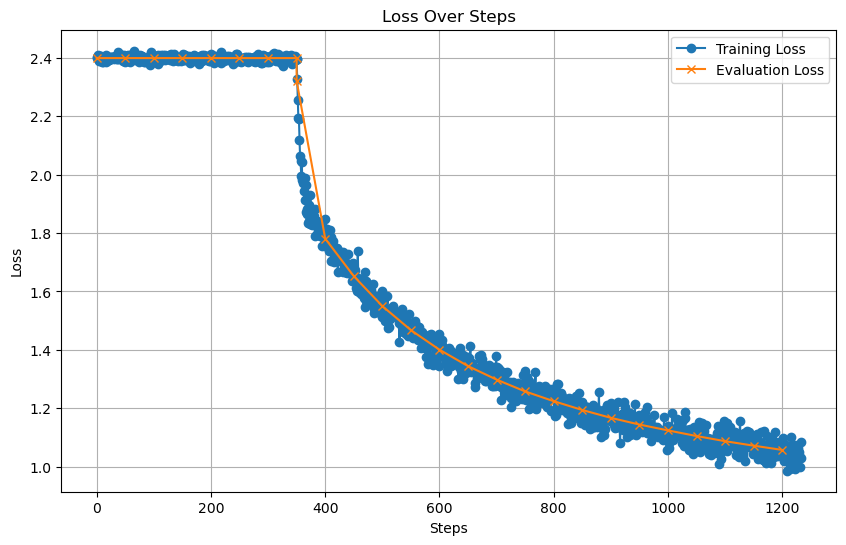

In [6]:
import matplotlib.pyplot as plt

# plot log_history
# Sorting values by steps to align the data points correctly
train_losses.sort(key=lambda x: x[0])
eval_losses.sort(key=lambda x: x[0])

# Plotting
plt.figure(figsize=(10, 6))
# Unzipping for plotting
if eval_losses != []:
    train_steps, train_loss_values = zip(*train_losses)
    eval_steps, eval_loss_values = zip(*eval_losses)
    plt.plot(train_steps, train_loss_values, label='Training Loss', marker='o')
    plt.plot(eval_steps, eval_loss_values, label='Evaluation Loss', marker='x')
else:
    train_steps, train_loss_values = zip(*train_losses)
    plt.plot(train_steps, train_loss_values, label='Training Loss', marker='o')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss Over Steps')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"

# input = "Hello, I am looking for a movie that will make me feel happy and excited. I love action movies with a lot of suspense and thrill. I also enjoy movies with a lot of drama and romance. Can you recommend a movie that will make me feel happy and excited? And please explain why you recommend this movie."
input = "Below is the previous historical purchases and reviews of the user:\n```\nItem title: The Gathering \n Item description: Product Description Gathering, The (1976 TVM) (DVD) Edward Asner and Maureen Stapleton star in this poignant and heartwarming story of the reconciliation between a successful businessman and the family he long ago abandoned to pursue a career. When Adam Thornton (Asner) learns that he is terminally ill, his estranged wife (Stapleton) insists that he spend one last Christmas with his now-adult children. Adam agrees--but insists that they not know of his illness. Now, in an idyllic, snow-covered New England town, the Thornton family tries to find reunion before it is too late. ]]> Amazon.com A fondly remembered holiday item from the latter phase of a great age of TV movies, The Gathering has an irresistible idea and a splendid central performance from Edward Asner, the actor for whom the term gruff but lovable was surely coined. We learn in the opening seconds of the film that Asner's character, a well-to-do businessman named Adam Thornton, has been diagnosed with a terminal illness; he's got three months left, at best. Time to make amends, and Adam reaches out to his ex-wife (Maureen Stapleton) and his mostly estranged kids for a final Christmas gathering. You won't find many surprises along the way, but the script by veteran screenwriter James Poe takes time for the small things, and gives Asner a believably conflicted character to play. It's directed by Randal Kleiser, who was just a year away from jumping to a big-screen career and scoring a smash with Grease . There's also some interest in watching a batch of young actors in the early stages of their careers: Bruce Davison, Gregory Harrison, Veronica Hamel, and Stephanie Zimbalist are in the Thornton extended family. If The Gathering has the basic look and feel of a TV movie (with wintry location work in Ohio), it nevertheless creates an honest, earned glow as it sorts through one man's final accounting of what has mattered in his life. --Robert Horton \n rating: 5.0 \n review: This version is an OFFICIAL release by MGM studios with closed captioning.<br /><br />Yes the movie looks a little dated, the clothes, the cars, etc...but that's just the external stuff.<br /><br />The story itself is timeless.<br /><br />It's nice to finally have on dvd with captions.  Thanks MGM and Amazon.-------\nItem title: 84 Charing Cross Road \n Item description: An American writer forms an enduring relationship with a London bookseller which is carried on over 20 years and across two continents. Genre: Feature Film-Drama Rating: PG Release Date: 23-SEP-2003 Media Type: DVD \n rating: 5.0 \n review: I bought the book because of  this movie.  Even when I read it I hear the voices of the these two wonderful actors.-------\nPlease infer the user's preference based on historical purchases and reviews, and then recommend an item for this user. Please just give the title of the recommended item."
# input = "hello, can you recommend me a random movie? Maybe a romantic one? And please describe the reason why you recommend this movie."

inputs = tokenizer(
[
    # "### Input:\n{inputs}\n\n### Response:{outputs}".format(inputs= input, outputs= ""),
    # "{inputs}".format(inputs= input),
    prompt_template.format(input, ""),    
], return_tensors = "pt").to("cuda")

model(**inputs).loss['logits'][-1].shape

torch.Size([1, 768])